# Quantum Sinkhorn — 4×4 Demo

This notebook demonstrates a minimal workflow for the classical Sinkhorn algorithm and the simulated hybrid quantum–classical version.

It generates a small 4×4 cost matrix, runs both algorithms, compares marginal errors per iteration, and reports the transport costs.

In [8]:
# --- Bootstrap de paths para importar desde src/ ---
import sys
from pathlib import Path

# Busca la raíz del repo (directorio que contiene 'src')
p = Path.cwd()
repo_root = None
while True:
    if (p / "src").exists():
        repo_root = p
        break
    if p.parent == p:
        break  # hemos llegado a la raíz del sistema
    p = p.parent

if repo_root is None:
    raise RuntimeError("No se encontró la carpeta 'src' en ningún directorio padre. "
                       "Abre el notebook desde el repo o ajusta la ruta manualmente.")

# Asegura que la raíz del repo está en sys.path
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print(f"Repo root detected: {repo_root}")
print("sys.path[0]:", sys.path[0])

# Ahora ya puedes importar como from src.…
from src.classical_sinkhorn import sinkhorn as classical_sinkhorn, compute_cost as classical_cost
from src.quantum_sinkhorn_sim import quantum_sinkhorn_sim, hadamard_cost_sim
from src import utils


Repo root detected: /workspaces/quantum-sinkhorn
sys.path[0]: /workspaces/quantum-sinkhorn


In [9]:
import sys, os
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if os.path.exists(os.path.join(repo_root, 'utils.py')):
    sys.path.append(repo_root)
print('Repo root:', repo_root)

Repo root: /workspaces/quantum-sinkhorn


In [10]:
import sys, os
sys.path.append(os.path.abspath("src"))

import numpy as np
import matplotlib.pyplot as plt
from src.classical_sinkhorn import sinkhorn as classical_sinkhorn, compute_cost as classical_cost
from src.quantum_sinkhorn_sim import quantum_sinkhorn_sim, hadamard_cost_sim
from src import utils

np.set_printoptions(precision=4, suppress=True)

## Generate a small problem (4×4)

We use a symmetric random cost matrix and uniform marginals.

In [17]:
n = 4
tau = 1.0
seed = 123

C = utils.generate_cost_matrix(n, seed=seed)
mu = utils.normalize_distribution(np.ones(n))
nu = utils.normalize_distribution(np.ones(n))

C

array([[0.6965, 0.5028, 0.3539, 0.4949],
       [0.5028, 0.4231, 0.6864, 0.3723],
       [0.3539, 0.6864, 0.3432, 0.5635],
       [0.4949, 0.3723, 0.5635, 0.738 ]])

## Run classical Sinkhorn

In [18]:
u_c, v_c, gamma_c, iters_c, err_hist_c = classical_sinkhorn(C, mu, nu, tau=tau, eps=1e-8, max_iter=10000, return_history=True)
cost_c = classical_cost(C, gamma_c)
iters_c, cost_c

(4, 0.49334964104763246)

## Run simulated quantum Sinkhorn

In [19]:
u_q, v_q, gamma_q, iters_q, info_q = quantum_sinkhorn_sim(
    C, mu, nu, tau=tau, tol=0.0015, ae_eps=0.002, max_iter=5000,
    shots_factor=100, use_exact_norm=True, seed=seed, return_history=True
)
exact_q_cost = classical_cost(C, gamma_q)
_, noisy_q_cost = hadamard_cost_sim(C, u_q, v_q, info_q['K'], np.random.default_rng(seed+1), ae_eps=0.02)
iters_q, exact_q_cost, noisy_q_cost

(5000, 0.49325403433649556, 0.4901919860215906)

## Compare convergence (L1 marginal error)

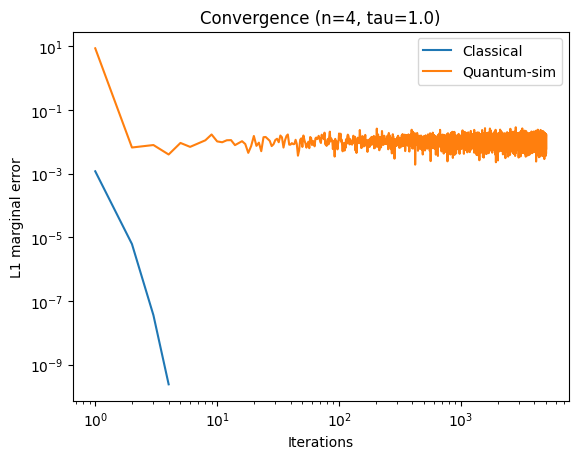

In [20]:
err_c = np.array(err_hist_c)
err_q = np.array(info_q['err_hist'])

plt.figure()
plt.loglog(np.arange(1, len(err_c)+1), err_c, label='Classical')
plt.loglog(np.arange(1, len(err_q)+1), err_q, label='Quantum-sim')
plt.xlabel('Iterations')
plt.ylabel('L1 marginal error')
plt.title(f'Convergence (n={n}, tau={tau})')
plt.legend()
plt.show()

## Inspect transport plans

In [21]:
print('Classical gamma:\n', gamma_c)
print('\nQuantum-sim gamma:\n', gamma_q)

Classical gamma:
 [[0.0519 0.0618 0.071  0.0654]
 [0.0618 0.0657 0.05   0.0725]
 [0.071  0.05   0.0697 0.0593]
 [0.0654 0.0725 0.0593 0.0528]]

Quantum-sim gamma:
 [[0.0516 0.062  0.0707 0.0651]
 [0.0617 0.0662 0.05   0.0726]
 [0.0711 0.0506 0.0699 0.0596]
 [0.0648 0.0727 0.0589 0.0525]]
